## Classification TBC

In [ ]:
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from PIL import Image
import torch.nn as nn
import torchvision.models
from torchsummary import summary
import timm
from efficientnet_pytorch import EfficientNet
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import time
from sklearn.metrics import confusion_matrix
import seaborn as sn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

In [ ]:
args = {}
args['lr'] = [0.001 , 0.0001 , 0.00001]
args['batch']= [16, 32, 64]
args['optimizer'] = ['adam', 'rmsprop', 'sgdm', 'sgd']
args['epoch'] = 20
args['class'] = ['Bakteri TBC', 'non TBC']

In [ ]:
def save_pickle(filename, data):
    with open(filename, 'wb') as file:
        pickle.dump(data, file)
    print(f'berhasil menyimpan pkl {filename}')

def write_pickle(filename):
    with open(filename, 'rb') as file:
        loaded_cache = pickle.load(file)
    print(f'Berhasil Load pkl {filename}')
    return loaded_cache

class efficientNetC(nn.Module):
    def __init__(self, version):
        super(efficientNetC, self).__init__()
        self.efficientnet = EfficientNet.from_pretrained('efficientnet-'+version)
        in_features = self.efficientnet._fc.in_features
        num_class = len(args['class'])
        self.efficientnet._fc = nn.Linear(in_features, num_class)
        self.version = version

    def forward(self, x):
        return self.efficientnet(x)

class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16):
        super(SEBlock, self).__init__()
        self.squeeze = nn.AdaptiveAvgPool2d(1)
        self.excitation = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction_ratio),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction_ratio, in_channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        y = self.squeeze(x)
        y = y.view(y.size(0), -1)
        y = self.excitation(y).view(y.size(0), -1, 1, 1)
        return x * y

class SEResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(SEResNetBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.se_block = SEBlock(out_channels)

        self.downsample = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out = self.se_block(out)

        identity = self.downsample(identity)

        out += identity
        out = self.relu(out)

        return out

class SEResNet18(nn.Module):
    def __init__(self, num_classes=2):
        super(SEResNet18, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(SEResNetBlock, 64, 2, stride=1)
        self.layer2 = self._make_layer(SEResNetBlock, 128, 2, stride=2)
        self.layer3 = self._make_layer(SEResNetBlock, 256, 2, stride=2)
        self.layer4 = self._make_layer(SEResNetBlock, 512, 2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, channels, blocks, stride=1):
        layers = []
        layers.append(block(self.in_channels, channels, stride))
        self.in_channels = channels
        for _ in range(1, blocks):
            layers.append(block(channels, channels, stride=1))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

class GoogLeNet(nn.Module):
    def __init__(self, num_classes=2):
        super(GoogLeNet, self).__init__()
        self.model = torchvision.models.googlenet(pretrained=True)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)
    def forward(self, x):
        x = self.model(x)
        return x


class MobileNetV2(nn.Module):
    def __init__(self, num_classes=2):
        super(MobileNetV2, self).__init__()
        self.model = torchvision.models.mobilenet_v2(num_classes=2)

    def forward(self, x):
        x = self.model(x)
        return x

class ResNet152V2(nn.Module):
    def __init__(self, num_classes=2):
        super(ResNet152V2, self).__init__()
        self.model = torchvision.models.resnet152(weights='IMAGENET1K_V2')
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)
    def forward(self, x):
        x = self.model(x)
        return x

class Classification:
    def __init__(self, str_model):
        self.modelname = str_model
        self.criterion = nn.CrossEntropyLoss()
        self.epochs = args['epoch']
        self.best_model = None

    def create_model(self, model_name):
        if model_name == 'efficientNet':
          return  efficientNetC("b0")
        elif model_name == 'se':
          return SEResNet18()
        elif model_name == 'googlenet':
          return GoogLeNet()
        elif model_name == 'mobilenetv2':
          return MobileNetV2()
        elif model_name == 'resnet152v2':
          return ResNet152V2()

    def compile(self, model, optim, lr):
        if optim == "rmsprop":
          self.model_optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
        elif optim == "adam":
          self.model_optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        elif optim == "sgdm":
          self.model_optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.001)
        elif optim == "sgd":
          self.model_optimizer = torch.optim.SGD(model.parameters(), lr=lr)


    def preprocessing(self, x, y, xval, yval, batch):
        if self.Train == True:
          self.data_x_train, self.data_y_train = x.permute(0,3,1,2)/255.0, y
          self.data_x_val, self.data_y_val = xval.permute(0,3,1,2)/255.0, yval

          self.train_loader = DataLoader(TensorDataset(self.data_x_train, self.data_y_train), batch_size = batch, shuffle=True)
          self.val_loader = DataLoader(TensorDataset(self.data_x_val, self.data_y_val), batch_size = batch, shuffle=True)

        else:
          self.data_x_test, self.data_y_test = x.permute(0,3,1,2)/255.0, y
          self.test_loader = DataLoader(TensorDataset(self.data_x_test, self.data_y_test), batch_size = batch, shuffle=True)

    def save_model(self, model, filename):
        torch.save(model.state_dict(), args['model']+filename+".pth")

    def load_model(self, model, filename, device):
        return torch.load(args['model']+filename+".pth", map_location=device)

    def train(self, model, optimizer, criterion, train_loader):
        model.train()
        running_loss = 0
        correct = 0
        total = 0
        alpha, beta = 1e-5, 1e-3
        for id_batch, (images, labels) in enumerate(train_loader):
            images = images.to(self.device)
            labels = labels.to(self.device)

            optimizer.zero_grad()
            outputs = model(images)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predict = torch.max(outputs.data, 1)
            correct += (predict == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total

        return model, train_loss, train_acc

    def valid(self, model, criterion, valid_loader):
        model.eval()
        running_loss = 0
        correct = 0
        total = 0
        all_prediction, all_target = [], []

        with torch.no_grad():

            for batch_idx, (images, labels) in enumerate(valid_loader):
                images = images.to(self.device)
                labels = labels.to(self.device)

                outputs = model(images)

                loss = criterion(outputs, labels)
                running_loss += loss.item()

                _, predict = torch.max(outputs.data, 1)
                correct += (predict == labels).sum().item()
                total += labels.size(0)


                all_prediction.extend(predict.cpu().numpy())
                all_target.extend(labels.cpu().numpy())

        val_loss = running_loss / len(valid_loader)
        val_acc = correct / total
        eval=self.evaluate(all_prediction, all_target)

        return model, val_loss, val_acc, eval

    def fit(self, X, y, xval, yval, device):
        self.Train = True
        self.device=device

        best_acc_tunning = 0
        ####tunning
        #lr, batch, optimizer
        for lr_use in args['lr']:
            for batch_use in args['batch']:
                for optimizer_use in args['optimizer']:

                    model_use = self.create_model(self.modelname)
                    model_use = model_use.to(self.device)
                    self.criterion = self.criterion.to(device)
                    model_stats = {}
                    loss_train, acc_train, loss_val, acc_val, perform=[], [], [], [], []
                    best_loss = 999
                    time_start = time.time()

                    proses_name = f"model_{self.modelname}_lr_{lr_use}_batch_{batch_use}_optimizer_{optimizer_use}"
                    print(f"Tunning {proses_name}")

                    self.compile(model_use, optimizer_use, lr_use)
                    self.preprocessing(X,y,xval,yval, batch_use)

                    for epoch in range(self.epochs):

                      model_use, train_loss, train_acc = self.train(model_use, self.model_optimizer, self.criterion, self.train_loader)
                      model_use, val_loss, val_acc, eval = self.valid(model_use, self.criterion, self.val_loader)

                      loss_train.append(train_loss)
                      acc_train.append(train_acc)
                      loss_val.append(val_loss)
                      acc_val.append(val_acc)
                      perform.append(eval)

                      #simpan model
                      print(f"Epoch : {epoch+1} train loss : {train_loss} train acc : {train_acc} val loss : {val_loss} val acc : {val_acc} ")
                      if train_loss < best_loss :
                          print("Menyimpan Model")
                          self.save_model(model_use, proses_name)
                          best_loss = train_loss
                    time_stop = time.time()

                    #simpan semua loss fold
                    model_stats['loss_training'], model_stats['acc_training']=loss_train, acc_train
                    model_stats['loss_validasi'], model_stats['acc_validasi']=loss_val, acc_val

                    df = pd.DataFrame(model_stats)
                    df.to_excel(args['performa_excel']+proses_name+".xlsx", index=False)

                    model_stats['timer']=(time_stop-time_start)
                    model_stats['perform']=perform
                    save_pickle(args['performa']+f"perform_{proses_name}.pkl", model_stats)
                    print(f"with time : {model_stats['timer']} loss : {loss_val[-1]} acc : {acc_val[-1]} precision : {model_stats['perform'][-1][1]} recall : {model_stats['perform'][-1][2]} f1 : {model_stats['perform'][-1][3]}")
                    if acc_val[-1] > best_acc_tunning:
                        best_acc_tunning = acc_val[-1]
                        self.best_model = proses_name
                    model_use=None
        print(f"FINAL BEST MODEL WITH ACC : {best_acc_tunning}")
        print(self.best_model)

    def best_model_graph(self):
      best_path = args['performa']+"perform_"+self.best_model+".pkl"
      best_perform = write_pickle(best_path)
      acc_train, acc_val, loss_train, loss_val, timer = best_perform['acc_training'], best_perform['acc_validasi'], best_perform['loss_training'], best_perform['loss_validasi'], best_perform['timer']

      print(f"Training Time for {timer}")
      plt.figure(figsize=(12, 5))
      plt.plot(loss_train, label='Training Loss')
      plt.plot(loss_val, label='Validasi Loss')
      plt.xlabel('Epoch')
      plt.ylabel('Loss')
      plt.title(f'loss {self.best_model}')
      plt.legend()
      plt.show()

      plt.figure(figsize=(12, 5))
      plt.plot(acc_train, label='Training Accuracy')
      plt.plot(acc_val, label='Validation Accuracu')
      plt.xlabel('Epoch')
      plt.ylabel('Accuracy')
      plt.title(f'Accuracy Of {self.best_model}')
      plt.legend()
      plt.show()

    def predict(self,  X,y, device):
      self.Train = False
      self.device = device
      model = self.create_model(self.modelname)
      # Split the string by underscores
      tokens = self.best_model.split('_')
      batch_index = tokens.index('batch')
      batch_size = int(tokens[batch_index + 1])

      model.load_state_dict(self.load_model(model, self.best_model, self.device) ,strict=False)
      self.preprocessing(X,y, None, None, batch_size)

      # testing phase
      _, test_loss, test_acc, perform = self.valid(model, self.criterion, self.test_loader)

      print(f"Hasil Testing")

      plt.figure(figsize=(6, 6))
      sn.heatmap(perform[4], annot=True, fmt='d', cmap='Blues', xticklabels=args['class'], yticklabels=args['class'])
      plt.xlabel('Predicted')
      plt.ylabel('Target')
      plt.title('Confusion Matrix')
      plt.show()

      print(f"Loss : {test_loss}")
      print(f"Accuracy : {test_acc}")
      print(f"Precision : {perform[1]}")
      print(f"Recall : {perform[2]}")
      print(f"F1-score : {perform[3]}")

    def evaluate(self, predict, target):
      conf_matrix = torch.from_numpy(confusion_matrix(target, predict))
      metrics_per_class = {}
      for i in range(conf_matrix.size(0)):
        TP = conf_matrix[i, i]
        FP = torch.sum(conf_matrix[:, i]) - TP
        FN = torch.sum(conf_matrix[i, :]) - TP
        TN = torch.sum(conf_matrix) - TP -FP -FN

        accuracy = (TP + TN) / torch.sum(conf_matrix)
        precision = TP / (TP + FP)
        recall = TP / (TP + FN)
        f1 = 2 * (precision * recall) / (precision + recall)

        metrics_per_class[args['class'][i]] = {
            'acc': accuracy.item(),
            'precision': precision.item(),
            'recall': recall.item(),
            'f1': f1.item()}
      accuracy_total = sum(metric['acc'] for metric in metrics_per_class.values()) / conf_matrix.size(0)
      precision_total = sum(metric['precision'] for metric in metrics_per_class.values()) / conf_matrix.size(0)
      recall_total = sum(metric['recall'] for metric in metrics_per_class.values()) / conf_matrix.size(0)
      f1_total = sum(metric['f1'] for metric in metrics_per_class.values()) / conf_matrix.size(0)
      return [accuracy_total, precision_total, recall_total, f1_total, conf_matrix, metrics_per_class]

## Training CNN
- EfficientNet
- Squeeze and Excitation
- GoogleNet
- ResNetV2
- ResNet152V2)

## A. EfficientNet

In [ ]:
# model = efficientNetC("b0")
classifier = Classification("efficientNet")
classifier.fit(xtrain_val, ytrain_val, xval, yval, 'cuda')

Loaded pretrained weights for efficientnet-b0
Tunning model_efficientNet_lr_0.001_batch_16_optimizer_adam
Epoch : 1 train loss : 0.21553947650553548 train acc : 0.9258343634116193 val loss : 1.736223505093501 val acc : 0.43349753694581283 
Menyimpan Model
Epoch : 2 train loss : 0.10217572504873662 train acc : 0.9703337453646477 val loss : 26.84928952730619 val acc : 0.541871921182266 
Menyimpan Model
Epoch : 3 train loss : 0.1251591484738039 train acc : 0.9678615574783683 val loss : 15.927088246895718 val acc : 0.5073891625615764 
Epoch : 4 train loss : 0.07625682446557809 train acc : 0.969097651421508 val loss : 242.3294082054725 val acc : 0.5369458128078818 
Menyimpan Model
Epoch : 5 train loss : 0.0925305775804993 train acc : 0.9715698393077874 val loss : 37.57104998368483 val acc : 0.4729064039408867 
Epoch : 6 train loss : 0.038487113480383126 train acc : 0.9938195302843016 val loss : 4.245617426358736 val acc : 0.5862068965517241 
Menyimpan Model
Epoch : 7 train loss : 0.10251571

Berhasil Load pkl drive/MyDrive/project/TBC-Project/performa/perform_model_efficientNet_lr_0.001_batch_32_optimizer_adam.pkl
Training Time for 122.81164193153381


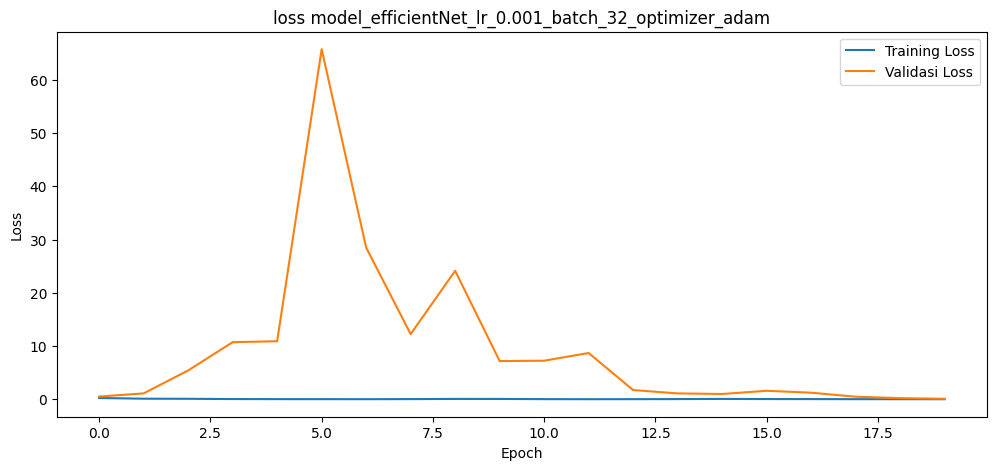

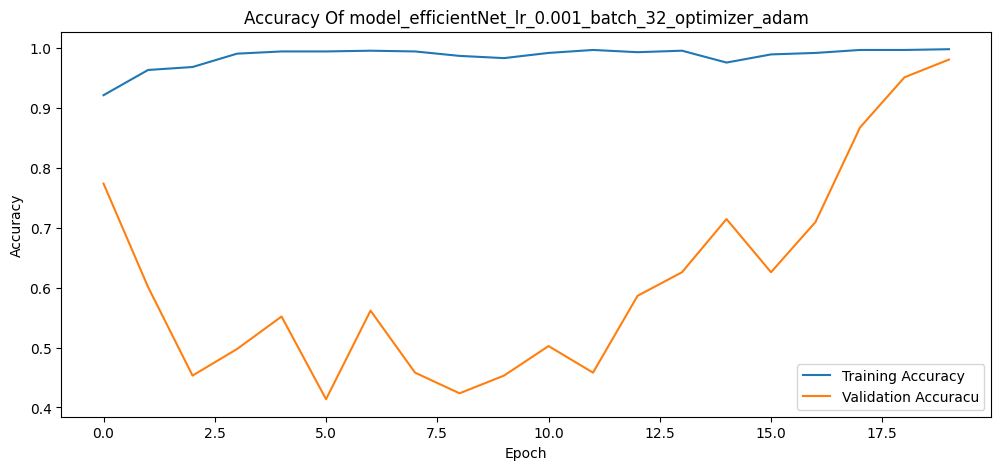

In [ ]:
classifier.best_model_graph()

Loaded pretrained weights for efficientnet-b0
Hasil Testing


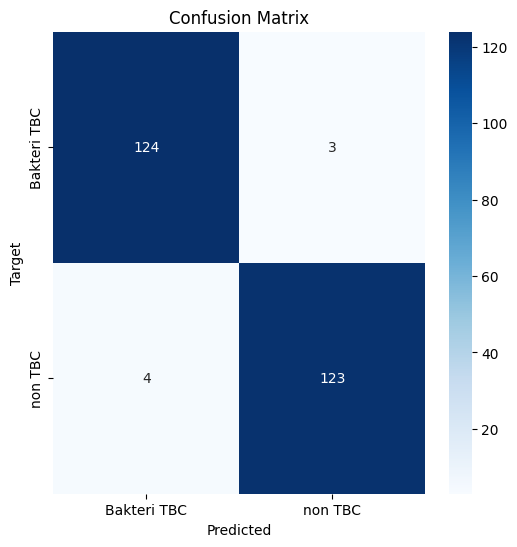

Loss : 0.16610169550403953
Accuracy : 0.9724409448818898
Precision : 0.972470223903656
Recall : 0.9724409580230713
F1-score : 0.9724405109882355


In [ ]:
classifier = Classification("efficientNet")
classifier.best_model = 'model_efficientNet_lr_0.001_batch_32_optimizer_adam'
classifier.predict(xtest, ytest, 'cpu')

## B. SE

In [ ]:
# model = efficientNetC("b0")
classifier = Classification("se")
classifier.fit(xtrain_val, ytrain_val, xval, yval, 'cuda')

Tunning model_se_lr_0.001_batch_16_optimizer_adam
Epoch : 1 train loss : 0.5132782275185865 train acc : 0.7935723114956736 val loss : 0.5077604490977067 val acc : 0.7438423645320197 
Menyimpan Model
Epoch : 2 train loss : 0.37374215105585024 train acc : 0.8405438813349815 val loss : 0.7057057940042936 val acc : 0.5812807881773399 
Menyimpan Model
Epoch : 3 train loss : 0.260181526927387 train acc : 0.9134734239802225 val loss : 0.3031326715762799 val acc : 0.9014778325123153 
Menyimpan Model
Epoch : 4 train loss : 0.20167336083364254 train acc : 0.9369592088998764 val loss : 0.3127681194589688 val acc : 0.8522167487684729 
Menyimpan Model
Epoch : 5 train loss : 0.18482082293314092 train acc : 0.9369592088998764 val loss : 0.5872707000145545 val acc : 0.8226600985221675 
Menyimpan Model
Epoch : 6 train loss : 0.18556650223977425 train acc : 0.934487021013597 val loss : 0.18545376867629015 val acc : 0.9556650246305419 
Epoch : 7 train loss : 0.16114168068138407 train acc : 0.945611866501

Berhasil Load pkl drive/MyDrive/project/TBC-Project/performa/perform_model_se_lr_0.0001_batch_16_optimizer_adam.pkl
Training Time for 67.89909362792969


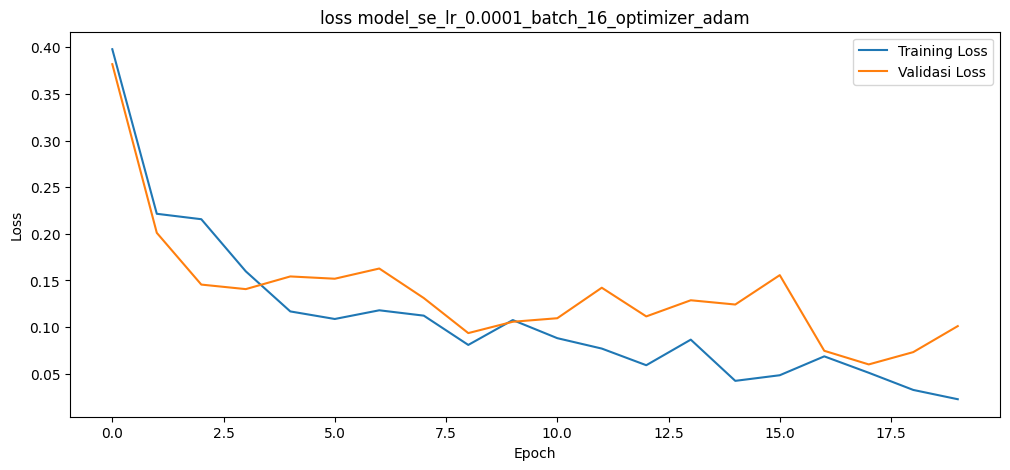

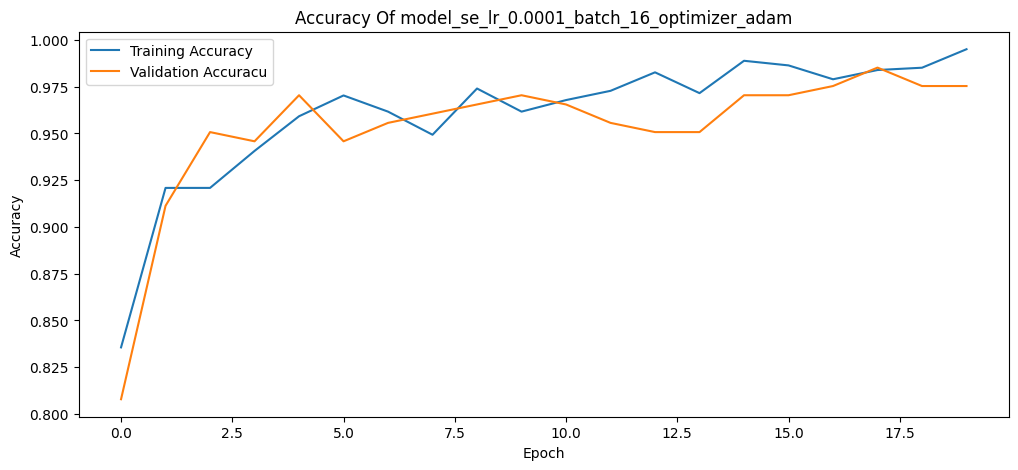

In [ ]:
classifier.best_model_graph()

Hasil Testing


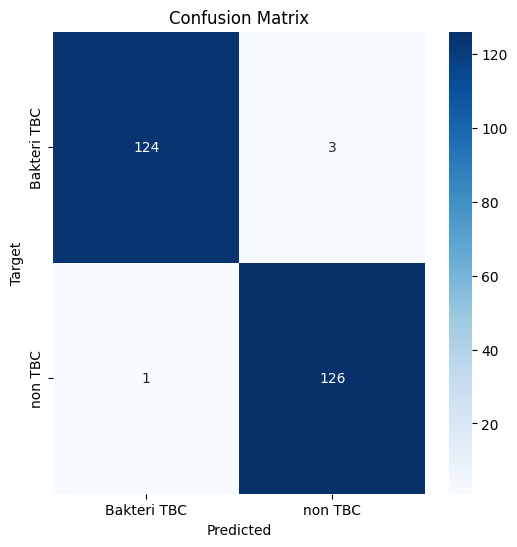

Loss : 0.06626732763834298
Accuracy : 0.984251968503937
Precision : 0.984372079372406
Recall : 0.9842519760131836
F1-score : 0.9842509925365448


In [ ]:
classifier.predict(xtest, ytest, 'cpu')

## C. GoogleNet

In [ ]:
classifier = Classification("googlenet")
classifier.fit(xtrain_val, ytrain_val, xval, yval, 'cuda')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 160MB/s]


Tunning model_googlenet_lr_0.001_batch_16_optimizer_adam
Epoch : 1 train loss : 0.33788639818336447 train acc : 0.865265760197775 val loss : 0.9929099260614469 val acc : 0.8177339901477833 
Menyimpan Model
Epoch : 2 train loss : 0.17053869341080094 train acc : 0.9468479604449939 val loss : 0.14969744676580796 val acc : 0.9310344827586207 
Menyimpan Model
Epoch : 3 train loss : 0.19220283800991728 train acc : 0.9283065512978986 val loss : 0.12042822889410533 val acc : 0.9507389162561576 
Epoch : 4 train loss : 0.09718786102409165 train acc : 0.9752781211372065 val loss : 0.2416337414716299 val acc : 0.9605911330049262 
Menyimpan Model
Epoch : 5 train loss : 0.13250387474602343 train acc : 0.9530284301606922 val loss : 0.14575438050983044 val acc : 0.9605911330049262 
Epoch : 6 train loss : 0.0762302832285344 train acc : 0.9789864029666254 val loss : 0.12501409145233294 val acc : 0.9704433497536946 
Menyimpan Model
Epoch : 7 train loss : 0.05890082758303512 train acc : 0.9740420271940667

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Tunning model_googlenet_lr_0.001_batch_16_optimizer_rmsprop
Epoch : 1 train loss : 0.5387425320405587 train acc : 0.7799752781211372 val loss : 0.9729623404832987 val acc : 0.6403940886699507 
Menyimpan Model
Epoch : 2 train loss : 0.2872097295361991 train acc : 0.9011124845488258 val loss : 0.2083786579851921 val acc : 0.9310344827586207 
Menyimpan Model
Epoch : 3 train loss : 0.2688635498577473 train acc : 0.9122373300370828 val loss : 0.18145803247506803 val acc : 0.9507389162561576 
Menyimpan Model
Epoch : 4 train loss : 0.1782928717998313 train acc : 0.930778739184178 val loss : 0.47033413184376865 val acc : 0.8669950738916257 
Menyimpan Model
Epoch : 5 train loss : 0.23019458934226456 train acc : 0.9184177997527813 val loss : 0.1993967667222023 val acc : 0.9310344827586207 
Epoch : 6 train loss : 0.1555877393476811 train acc : 0.9431396786155748 val loss : 0.5670748662490112 val acc : 0.8472906403940886 
Menyimpan Model
Epoch : 7 train loss : 0.14493705149666936 train acc : 0.951

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch : 1 train loss : 0.6863130108982909 train acc : 0.5587144622991347 val loss : 0.6667426228523254 val acc : 0.6551724137931034 
Menyimpan Model
Epoch : 2 train loss : 0.6382179599182278 train acc : 0.6501854140914709 val loss : 0.6020538119169382 val acc : 0.7339901477832512 
Menyimpan Model
Epoch : 3 train loss : 0.5850138944738051 train acc : 0.7428924598269468 val loss : 0.5526649608061864 val acc : 0.812807881773399 
Menyimpan Model
Epoch : 4 train loss : 0.5403625637877221 train acc : 0.7799752781211372 val loss : 0.515612753537985 val acc : 0.8472906403940886 
Menyimpan Model
Epoch : 5 train loss : 0.5068345186757106 train acc : 0.8071693448702101 val loss : 0.4658761758070726 val acc : 0.8817733990147784 
Menyimpan Model
Epoch : 6 train loss : 0.46407517147999183 train acc : 0.8504326328800988 val loss : 0.43077279054201567 val acc : 0.9064039408866995 
Menyimpan Model
Epoch : 7 train loss : 0.4322536155289295 train acc : 0.861557478368356 val loss : 0.41968830273701596 val

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch : 1 train loss : 0.6973418301227046 train acc : 0.5290482076637825 val loss : 0.6737804733789884 val acc : 0.6157635467980296 
Menyimpan Model
Epoch : 2 train loss : 0.6301057455586452 train acc : 0.6773794808405439 val loss : 0.612793165903825 val acc : 0.7487684729064039 
Menyimpan Model
Epoch : 3 train loss : 0.5831338663895925 train acc : 0.7564894932014833 val loss : 0.581788012614617 val acc : 0.7635467980295566 
Menyimpan Model
Epoch : 4 train loss : 0.5498505006818211 train acc : 0.7750309023485785 val loss : 0.5481705390490018 val acc : 0.8177339901477833 
Menyimpan Model
Epoch : 5 train loss : 0.5002211016767165 train acc : 0.8343634116192831 val loss : 0.4924542697576376 val acc : 0.8571428571428571 
Menyimpan Model
Epoch : 6 train loss : 0.4585808468799965 train acc : 0.8825710754017305 val loss : 0.45116293659577 val acc : 0.8866995073891626 
Menyimpan Model
Epoch : 7 train loss : 0.4177011683875439 train acc : 0.8677379480840544 val loss : 0.42075409568273103 val ac

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch : 1 train loss : 0.24085480340111715 train acc : 0.8974042027194067 val loss : 0.3089076855352947 val acc : 0.8620689655172413 
Menyimpan Model
Epoch : 2 train loss : 0.126092293084814 train acc : 0.9567367119901112 val loss : 0.14130070579371282 val acc : 0.9261083743842364 
Menyimpan Model
Epoch : 3 train loss : 0.07965290979840435 train acc : 0.9728059332509271 val loss : 0.27495445936386076 val acc : 0.9507389162561576 
Menyimpan Model
Epoch : 4 train loss : 0.1007120161353109 train acc : 0.965389369592089 val loss : 0.12064017648143428 val acc : 0.9655172413793104 
Epoch : 5 train loss : 0.09190576426828137 train acc : 0.9703337453646477 val loss : 0.08371769157903534 val acc : 0.9655172413793104 
Epoch : 6 train loss : 0.039505490442164816 train acc : 0.9839307787391842 val loss : 0.1564804113336972 val acc : 0.9605911330049262 
Menyimpan Model
Epoch : 7 train loss : 0.07737912581517147 train acc : 0.9789864029666254 val loss : 0.13108086532780103 val acc : 0.96059113300492

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Tunning model_googlenet_lr_0.001_batch_32_optimizer_rmsprop
Epoch : 1 train loss : 0.6535702450917318 train acc : 0.754017305315204 val loss : 0.6850249086107526 val acc : 0.6945812807881774 
Menyimpan Model
Epoch : 2 train loss : 0.2862716279923916 train acc : 0.896168108776267 val loss : 1.0192189727510725 val acc : 0.4729064039408867 
Menyimpan Model
Epoch : 3 train loss : 0.20315555741007513 train acc : 0.9295426452410384 val loss : 0.19679852575063705 val acc : 0.9310344827586207 
Menyimpan Model
Epoch : 4 train loss : 0.1935497634112835 train acc : 0.9258343634116193 val loss : 0.2074503985100559 val acc : 0.9310344827586207 
Menyimpan Model
Epoch : 5 train loss : 0.15027528044839317 train acc : 0.9604449938195303 val loss : 0.28826684824057985 val acc : 0.916256157635468 
Menyimpan Model
Epoch : 6 train loss : 0.12208917550742626 train acc : 0.9555006180469716 val loss : 0.17303355011556829 val acc : 0.9359605911330049 
Menyimpan Model
Epoch : 7 train loss : 0.19856352946506098 

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch : 1 train loss : 0.7039463222026825 train acc : 0.5352286773794809 val loss : 0.6976164749690464 val acc : 0.46798029556650245 
Menyimpan Model
Epoch : 2 train loss : 0.6418968026454632 train acc : 0.6625463535228677 val loss : 0.6249567270278931 val acc : 0.7142857142857143 
Menyimpan Model
Epoch : 3 train loss : 0.6082832836187803 train acc : 0.7441285537700866 val loss : 0.5985442655427116 val acc : 0.812807881773399 
Menyimpan Model
Epoch : 4 train loss : 0.5733637099082654 train acc : 0.7935723114956736 val loss : 0.5578877670424325 val acc : 0.8325123152709359 
Menyimpan Model
Epoch : 5 train loss : 0.5455880130712802 train acc : 0.8380716934487021 val loss : 0.5484109606061663 val acc : 0.8472906403940886 
Menyimpan Model
Epoch : 6 train loss : 0.5173467775950065 train acc : 0.8417799752781211 val loss : 0.5178602933883667 val acc : 0.8817733990147784 
Menyimpan Model
Epoch : 7 train loss : 0.49110435866392577 train acc : 0.8813349814585909 val loss : 0.47533170666013447 v

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch : 1 train loss : 0.6753939665280856 train acc : 0.5698393077873919 val loss : 0.6836288145610264 val acc : 0.5566502463054187 
Menyimpan Model
Epoch : 2 train loss : 0.6411543557277093 train acc : 0.6835599505562423 val loss : 0.637727039200919 val acc : 0.7241379310344828 
Menyimpan Model
Epoch : 3 train loss : 0.6104711867295779 train acc : 0.7292954264524104 val loss : 0.609917163848877 val acc : 0.7635467980295566 
Menyimpan Model
Epoch : 4 train loss : 0.582137412749804 train acc : 0.7787391841779975 val loss : 0.5784303971699306 val acc : 0.7881773399014779 
Menyimpan Model
Epoch : 5 train loss : 0.5457074355620605 train acc : 0.826946847960445 val loss : 0.5551427943365914 val acc : 0.812807881773399 
Menyimpan Model
Epoch : 6 train loss : 0.5221947294015151 train acc : 0.826946847960445 val loss : 0.5136191717215947 val acc : 0.8866995073891626 
Menyimpan Model
Epoch : 7 train loss : 0.4881864935159683 train acc : 0.8566131025957973 val loss : 0.49906129922185627 val acc 

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch : 1 train loss : 0.24741004350093695 train acc : 0.8912237330037083 val loss : 0.8202411010861397 val acc : 0.7635467980295566 
Menyimpan Model
Epoch : 2 train loss : 0.1719103166117118 train acc : 0.9443757725587144 val loss : 0.27898295875638723 val acc : 0.8866995073891626 
Menyimpan Model
Epoch : 3 train loss : 0.06205971517528479 train acc : 0.9740420271940667 val loss : 0.09663771791383624 val acc : 0.9655172413793104 
Menyimpan Model
Epoch : 4 train loss : 0.04289478174625681 train acc : 0.9851668726823238 val loss : 0.1052584508433938 val acc : 0.9507389162561576 
Menyimpan Model
Epoch : 5 train loss : 0.0571977158005421 train acc : 0.9802224969097652 val loss : 0.1915256343781948 val acc : 0.9359605911330049 
Epoch : 6 train loss : 0.03982518874825193 train acc : 0.9913473423980222 val loss : 0.14957295265048742 val acc : 0.9605911330049262 
Menyimpan Model
Epoch : 7 train loss : 0.030565835034044888 train acc : 0.9901112484548825 val loss : 0.08204096066765487 val acc :

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Tunning model_googlenet_lr_0.001_batch_64_optimizer_rmsprop
Epoch : 1 train loss : 0.9945825475912827 train acc : 0.6056860321384425 val loss : 0.5983105003833771 val acc : 0.6157635467980296 
Menyimpan Model
Epoch : 2 train loss : 0.24426828152858293 train acc : 0.9023485784919654 val loss : 0.31194656156003475 val acc : 0.8325123152709359 
Menyimpan Model
Epoch : 3 train loss : 0.17682991176843643 train acc : 0.9381953028430161 val loss : 0.30542246624827385 val acc : 0.8817733990147784 
Menyimpan Model
Epoch : 4 train loss : 0.140255508514551 train acc : 0.9493201483312732 val loss : 0.39155805855989456 val acc : 0.8177339901477833 
Menyimpan Model
Epoch : 5 train loss : 0.11802430193011577 train acc : 0.957972805933251 val loss : 0.14484437368810177 val acc : 0.9458128078817734 
Menyimpan Model
Epoch : 6 train loss : 0.07961674622045113 train acc : 0.9752781211372065 val loss : 0.13207929488271475 val acc : 0.9211822660098522 
Menyimpan Model
Epoch : 7 train loss : 0.08306394374141

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch : 1 train loss : 0.7029531368842492 train acc : 0.5030902348578492 val loss : 0.6614453196525574 val acc : 0.6157635467980296 
Menyimpan Model
Epoch : 2 train loss : 0.6732530639721797 train acc : 0.580964153275649 val loss : 0.6634571999311447 val acc : 0.645320197044335 
Menyimpan Model
Epoch : 3 train loss : 0.6501672497162452 train acc : 0.6242274412855378 val loss : 0.6324364244937897 val acc : 0.6847290640394089 
Menyimpan Model
Epoch : 4 train loss : 0.6221763078983014 train acc : 0.7045735475896168 val loss : 0.6200834065675735 val acc : 0.6945812807881774 
Menyimpan Model
Epoch : 5 train loss : 0.6041394793070279 train acc : 0.7218788627935723 val loss : 0.614108145236969 val acc : 0.7142857142857143 
Menyimpan Model
Epoch : 6 train loss : 0.5808539573962872 train acc : 0.7725587144622992 val loss : 0.588345542550087 val acc : 0.7684729064039408 
Menyimpan Model
Epoch : 7 train loss : 0.5664206743240356 train acc : 0.8195302843016069 val loss : 0.5788194239139557 val acc

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Tunning model_googlenet_lr_0.001_batch_64_optimizer_sgd
Epoch : 1 train loss : 0.7213036051163306 train acc : 0.5043263288009888 val loss : 0.6810170263051987 val acc : 0.4975369458128079 
Menyimpan Model
Epoch : 2 train loss : 0.688262375501486 train acc : 0.546353522867738 val loss : 0.6720534712076187 val acc : 0.6108374384236454 
Menyimpan Model
Epoch : 3 train loss : 0.6633616594167856 train acc : 0.595797280593325 val loss : 0.6570789068937302 val acc : 0.6354679802955665 
Menyimpan Model
Epoch : 4 train loss : 0.6399285243107722 train acc : 0.6637824474660075 val loss : 0.6318847090005875 val acc : 0.7339901477832512 
Menyimpan Model
Epoch : 5 train loss : 0.6303407091360825 train acc : 0.7008652657601978 val loss : 0.6122856885194778 val acc : 0.7389162561576355 
Menyimpan Model
Epoch : 6 train loss : 0.6046537298422593 train acc : 0.7404202719406675 val loss : 0.609597235918045 val acc : 0.7438423645320197 
Menyimpan Model
Epoch : 7 train loss : 0.5964610714178818 train acc : 

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch : 1 train loss : 0.37344391614783046 train acc : 0.8467243510506799 val loss : 0.13366949902131006 val acc : 0.9605911330049262 
Menyimpan Model
Epoch : 2 train loss : 0.12626858143245473 train acc : 0.9555006180469716 val loss : 0.10714716349656765 val acc : 0.9704433497536946 
Menyimpan Model
Epoch : 3 train loss : 0.07820605599851001 train acc : 0.9752781211372065 val loss : 0.05637393447642143 val acc : 0.9852216748768473 
Menyimpan Model
Epoch : 4 train loss : 0.05472909077527184 train acc : 0.9814585908529048 val loss : 0.05348643495772894 val acc : 0.9753694581280788 
Menyimpan Model
Epoch : 5 train loss : 0.05741513915378235 train acc : 0.9826946847960445 val loss : 0.08444762244247474 val acc : 0.9655172413793104 
Epoch : 6 train loss : 0.0349983820993015 train acc : 0.9888751545117429 val loss : 0.061817390038273655 val acc : 0.9753694581280788 
Menyimpan Model
Epoch : 7 train loss : 0.014897618506688113 train acc : 0.9975278121137207 val loss : 0.05404367269231723 val 

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Tunning model_googlenet_lr_0.0001_batch_16_optimizer_rmsprop
Epoch : 1 train loss : 0.22212915217467383 train acc : 0.9147095179233622 val loss : 0.10509424513349166 val acc : 0.9556650246305419 
Menyimpan Model
Epoch : 2 train loss : 0.06094999355720539 train acc : 0.9851668726823238 val loss : 0.11216346547007561 val acc : 0.9458128078817734 
Menyimpan Model
Epoch : 3 train loss : 0.03543990577443266 train acc : 0.9901112484548825 val loss : 0.09886043475797543 val acc : 0.9655172413793104 
Menyimpan Model
Epoch : 4 train loss : 0.07495190656068278 train acc : 0.9814585908529048 val loss : 0.10637555547201863 val acc : 0.9655172413793104 
Epoch : 5 train loss : 0.04980022532810621 train acc : 0.9864029666254636 val loss : 0.14372326673653263 val acc : 0.9605911330049262 
Epoch : 6 train loss : 0.017841542431829022 train acc : 0.9950556242274413 val loss : 0.11287934032197182 val acc : 0.9655172413793104 
Menyimpan Model
Epoch : 7 train loss : 0.00959125054913445 train acc : 0.9975278

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch : 1 train loss : 0.7225501537322998 train acc : 0.5055624227441285 val loss : 0.7157441148391137 val acc : 0.5172413793103449 
Menyimpan Model
Epoch : 2 train loss : 0.7084061176169152 train acc : 0.5030902348578492 val loss : 0.6977191796669593 val acc : 0.5566502463054187 
Menyimpan Model
Epoch : 3 train loss : 0.690235130927142 train acc : 0.5550061804697157 val loss : 0.6916085940140945 val acc : 0.5763546798029556 
Menyimpan Model
Epoch : 4 train loss : 0.6850824192458508 train acc : 0.5562422744128553 val loss : 0.6831124149836026 val acc : 0.5862068965517241 
Menyimpan Model
Epoch : 5 train loss : 0.6733107578520682 train acc : 0.5624227441285538 val loss : 0.6765502141072199 val acc : 0.5862068965517241 
Menyimpan Model
Epoch : 6 train loss : 0.6747734336292043 train acc : 0.5686032138442522 val loss : 0.668614754310021 val acc : 0.6157635467980296 
Epoch : 7 train loss : 0.6668564525305056 train acc : 0.6007416563658838 val loss : 0.6580484876265893 val acc : 0.640394088

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch : 1 train loss : 0.7182258098733192 train acc : 0.4758961681087763 val loss : 0.7111212886296786 val acc : 0.47783251231527096 
Menyimpan Model
Epoch : 2 train loss : 0.7109975592762816 train acc : 0.4857849196538937 val loss : 0.7075029290639437 val acc : 0.4975369458128079 
Menyimpan Model
Epoch : 3 train loss : 0.70974049614925 train acc : 0.49814585908529047 val loss : 0.7017960548400879 val acc : 0.5221674876847291 
Menyimpan Model
Epoch : 4 train loss : 0.6924265634779837 train acc : 0.5414091470951793 val loss : 0.6904575962286729 val acc : 0.5073891625615764 
Menyimpan Model
Epoch : 5 train loss : 0.6827916970439986 train acc : 0.5500618046971569 val loss : 0.6856476756242605 val acc : 0.5665024630541872 
Menyimpan Model
Epoch : 6 train loss : 0.6855893029886133 train acc : 0.5475896168108776 val loss : 0.6771279069093558 val acc : 0.5517241379310345 
Epoch : 7 train loss : 0.6673576282519921 train acc : 0.6106304079110012 val loss : 0.6726822165342478 val acc : 0.5763546

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Tunning model_googlenet_lr_0.0001_batch_32_optimizer_adam
Epoch : 1 train loss : 0.4121164301267037 train acc : 0.8207663782447466 val loss : 0.27635262480803896 val acc : 0.9113300492610837 
Menyimpan Model
Epoch : 2 train loss : 0.10311657878068778 train acc : 0.9752781211372065 val loss : 0.1207612758236272 val acc : 0.9507389162561576 
Menyimpan Model
Epoch : 3 train loss : 0.05455721040757803 train acc : 0.9839307787391842 val loss : 0.0820153219891446 val acc : 0.9655172413793104 
Menyimpan Model
Epoch : 4 train loss : 0.03925397021409411 train acc : 0.9913473423980222 val loss : 0.09640520066022873 val acc : 0.9704433497536946 
Menyimpan Model
Epoch : 5 train loss : 0.06014511386792247 train acc : 0.9864029666254636 val loss : 0.08304206069026675 val acc : 0.9556650246305419 
Epoch : 6 train loss : 0.028496807100824438 train acc : 0.992583436341162 val loss : 0.0775290337790336 val acc : 0.9655172413793104 
Menyimpan Model
Epoch : 7 train loss : 0.031098489354078013 train acc : 

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch : 1 train loss : 0.2263801097869873 train acc : 0.9023485784919654 val loss : 0.25251064343111856 val acc : 0.8916256157635468 
Menyimpan Model
Epoch : 2 train loss : 0.05685988559315984 train acc : 0.9802224969097652 val loss : 0.08258871201957975 val acc : 0.9655172413793104 
Menyimpan Model
Epoch : 3 train loss : 0.022733101012328498 train acc : 0.9938195302843016 val loss : 0.089852669143251 val acc : 0.9556650246305419 
Menyimpan Model
Epoch : 4 train loss : 0.01463176276928817 train acc : 0.9962917181705809 val loss : 0.04630863932626588 val acc : 0.9802955665024631 
Menyimpan Model
Epoch : 5 train loss : 0.027064527125241093 train acc : 0.992583436341162 val loss : 0.07973558635317854 val acc : 0.9704433497536946 
Epoch : 6 train loss : 0.01270143879362597 train acc : 0.9975278121137207 val loss : 0.051250763703137636 val acc : 0.9704433497536946 
Menyimpan Model
Epoch : 7 train loss : 0.013620581352510132 train acc : 0.9962917181705809 val loss : 0.07903245103079826 val a

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Tunning model_googlenet_lr_0.0001_batch_32_optimizer_sgdm
Epoch : 1 train loss : 0.7043854685930105 train acc : 0.515451174289246 val loss : 0.7176236936024257 val acc : 0.4433497536945813 
Menyimpan Model
Epoch : 2 train loss : 0.6953902565515958 train acc : 0.5142150803461063 val loss : 0.6943579230989728 val acc : 0.541871921182266 
Menyimpan Model
Epoch : 3 train loss : 0.6899793789936945 train acc : 0.546353522867738 val loss : 0.7020873342241559 val acc : 0.5073891625615764 
Menyimpan Model
Epoch : 4 train loss : 0.6957556055142329 train acc : 0.5129789864029666 val loss : 0.6917323129517692 val acc : 0.5270935960591133 
Epoch : 5 train loss : 0.682806494144293 train acc : 0.5512978986402967 val loss : 0.6992722749710083 val acc : 0.5369458128078818 
Menyimpan Model
Epoch : 6 train loss : 0.6789775513685666 train acc : 0.5550061804697157 val loss : 0.6857437746865409 val acc : 0.5369458128078818 
Menyimpan Model
Epoch : 7 train loss : 0.6760251980561477 train acc : 0.594561186650

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Tunning model_googlenet_lr_0.0001_batch_32_optimizer_sgd
Epoch : 1 train loss : 0.7305498191943536 train acc : 0.5129789864029666 val loss : 0.6845388923372541 val acc : 0.5221674876847291 
Menyimpan Model
Epoch : 2 train loss : 0.707497225357936 train acc : 0.5203955500618047 val loss : 0.6737391352653503 val acc : 0.5517241379310345 
Menyimpan Model
Epoch : 3 train loss : 0.7026541370611924 train acc : 0.5241038318912238 val loss : 0.6809815679277692 val acc : 0.5665024630541872 
Menyimpan Model
Epoch : 4 train loss : 0.693592566710252 train acc : 0.5389369592088998 val loss : 0.6735713396753583 val acc : 0.5911330049261084 
Menyimpan Model
Epoch : 5 train loss : 0.6929130416650039 train acc : 0.5426452410383189 val loss : 0.6652539542743138 val acc : 0.6305418719211823 
Menyimpan Model
Epoch : 6 train loss : 0.679090713079159 train acc : 0.5512978986402967 val loss : 0.663113670689719 val acc : 0.6403940886699507 
Menyimpan Model
Epoch : 7 train loss : 0.6681761741638184 train acc :

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Tunning model_googlenet_lr_0.0001_batch_64_optimizer_adam
Epoch : 1 train loss : 0.5178610522013444 train acc : 0.7626699629171817 val loss : 0.552763894200325 val acc : 0.7881773399014779 
Menyimpan Model
Epoch : 2 train loss : 0.18519725707861093 train acc : 0.9666254635352287 val loss : 0.30645494908094406 val acc : 0.9064039408866995 
Menyimpan Model
Epoch : 3 train loss : 0.07771426095412327 train acc : 0.9839307787391842 val loss : 0.17796719633042812 val acc : 0.9507389162561576 
Menyimpan Model
Epoch : 4 train loss : 0.03247919320487059 train acc : 0.9950556242274413 val loss : 0.10395236127078533 val acc : 0.9704433497536946 
Menyimpan Model
Epoch : 5 train loss : 0.02337197228693045 train acc : 0.9962917181705809 val loss : 0.06386355846188962 val acc : 0.9655172413793104 
Menyimpan Model
Epoch : 6 train loss : 0.01930069328787235 train acc : 0.9950556242274413 val loss : 0.10065310169011354 val acc : 0.9753694581280788 
Menyimpan Model
Epoch : 7 train loss : 0.01454299004175

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Tunning model_googlenet_lr_0.0001_batch_64_optimizer_rmsprop
Epoch : 1 train loss : 0.24243766012100074 train acc : 0.8850432632880099 val loss : 0.5483406409621239 val acc : 0.7586206896551724 
Menyimpan Model
Epoch : 2 train loss : 0.07527571085553902 train acc : 0.9765142150803461 val loss : 0.24970283173024654 val acc : 0.9014778325123153 
Menyimpan Model
Epoch : 3 train loss : 0.01805063534098176 train acc : 0.9987639060568603 val loss : 0.10894353850744665 val acc : 0.9655172413793104 
Menyimpan Model
Epoch : 4 train loss : 0.007678697243905985 train acc : 1.0 val loss : 0.0776142009999603 val acc : 0.9753694581280788 
Menyimpan Model
Epoch : 5 train loss : 0.006756444157172854 train acc : 1.0 val loss : 0.07485982275102288 val acc : 0.9556650246305419 
Menyimpan Model
Epoch : 6 train loss : 0.004509778138106832 train acc : 1.0 val loss : 0.09979212004691362 val acc : 0.9605911330049262 
Menyimpan Model
Epoch : 7 train loss : 0.002626887710693364 train acc : 1.0 val loss : 0.0652

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Tunning model_googlenet_lr_0.0001_batch_64_optimizer_sgdm
Epoch : 1 train loss : 0.7161247134208679 train acc : 0.511742892459827 val loss : 0.7116830497980118 val acc : 0.5467980295566502 
Menyimpan Model
Epoch : 2 train loss : 0.7060092320808997 train acc : 0.5179233621755254 val loss : 0.6845997124910355 val acc : 0.5073891625615764 
Menyimpan Model
Epoch : 3 train loss : 0.689505357008714 train acc : 0.5216316440049443 val loss : 0.7012410312891006 val acc : 0.5172413793103449 
Menyimpan Model
Epoch : 4 train loss : 0.6846054379756634 train acc : 0.5500618046971569 val loss : 0.6928846538066864 val acc : 0.5270935960591133 
Menyimpan Model
Epoch : 5 train loss : 0.683855822453132 train acc : 0.5624227441285538 val loss : 0.7002566009759903 val acc : 0.5714285714285714 
Menyimpan Model
Epoch : 6 train loss : 0.6846210131278405 train acc : 0.5500618046971569 val loss : 0.6739054322242737 val acc : 0.5862068965517241 
Epoch : 7 train loss : 0.6782542054469769 train acc : 0.58220024721

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Tunning model_googlenet_lr_0.0001_batch_64_optimizer_sgd
Epoch : 1 train loss : 0.7178667371089642 train acc : 0.5105067985166872 val loss : 0.6830201596021652 val acc : 0.5221674876847291 
Menyimpan Model
Epoch : 2 train loss : 0.7078579251582806 train acc : 0.4919653893695921 val loss : 0.7107478380203247 val acc : 0.4630541871921182 
Menyimpan Model
Epoch : 3 train loss : 0.707355627646813 train acc : 0.5080346106304079 val loss : 0.726917639374733 val acc : 0.4827586206896552 
Menyimpan Model
Epoch : 4 train loss : 0.7121782211156992 train acc : 0.5166872682323856 val loss : 0.7098063975572586 val acc : 0.5073891625615764 
Epoch : 5 train loss : 0.6986480171863849 train acc : 0.5265760197775031 val loss : 0.7068391442298889 val acc : 0.5073891625615764 
Menyimpan Model
Epoch : 6 train loss : 0.7028482785591712 train acc : 0.5203955500618047 val loss : 0.676678404211998 val acc : 0.4975369458128079 
Epoch : 7 train loss : 0.6978407548024104 train acc : 0.5265760197775031 val loss : 

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Tunning model_googlenet_lr_1e-05_batch_16_optimizer_adam
Epoch : 1 train loss : 0.6508737825879863 train acc : 0.6613102595797281 val loss : 0.590205756517557 val acc : 0.8275862068965517 
Menyimpan Model
Epoch : 2 train loss : 0.5241792640265297 train acc : 0.8380716934487021 val loss : 0.47885191211333644 val acc : 0.896551724137931 
Menyimpan Model
Epoch : 3 train loss : 0.4307972163546319 train acc : 0.8739184177997528 val loss : 0.38838452330002415 val acc : 0.9113300492610837 
Menyimpan Model
Epoch : 4 train loss : 0.34945925485854057 train acc : 0.9134734239802225 val loss : 0.3179366084245535 val acc : 0.916256157635468 
Menyimpan Model
Epoch : 5 train loss : 0.26851267411428337 train acc : 0.9332509270704573 val loss : 0.24487526829426104 val acc : 0.9458128078817734 
Menyimpan Model
Epoch : 6 train loss : 0.21114299095728817 train acc : 0.9592088998763906 val loss : 0.1960255091006939 val acc : 0.9556650246305419 
Menyimpan Model
Epoch : 7 train loss : 0.17531851021682515 tra

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch : 1 train loss : 0.5324698984622955 train acc : 0.7713226205191595 val loss : 0.4434890609521132 val acc : 0.8472906403940886 
Menyimpan Model
Epoch : 2 train loss : 0.3560796231031418 train acc : 0.9035846724351051 val loss : 0.3114116375262921 val acc : 0.916256157635468 
Menyimpan Model
Epoch : 3 train loss : 0.2528798048402749 train acc : 0.9394313967861557 val loss : 0.23954293934198526 val acc : 0.9310344827586207 
Menyimpan Model
Epoch : 4 train loss : 0.1921722887485635 train acc : 0.9592088998763906 val loss : 0.1853568318944711 val acc : 0.9655172413793104 
Menyimpan Model
Epoch : 5 train loss : 0.17428814824305328 train acc : 0.9604449938195303 val loss : 0.14822128930917153 val acc : 0.9753694581280788 
Menyimpan Model
Epoch : 6 train loss : 0.13071711821591153 train acc : 0.9728059332509271 val loss : 0.13164264479508767 val acc : 0.9753694581280788 
Menyimpan Model
Epoch : 7 train loss : 0.11278331425844454 train acc : 0.9802224969097652 val loss : 0.109993116786846

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Tunning model_googlenet_lr_1e-05_batch_16_optimizer_sgdm
Epoch : 1 train loss : 0.7380805389553893 train acc : 0.4746600741656366 val loss : 0.7505356073379517 val acc : 0.4729064039408867 
Menyimpan Model
Epoch : 2 train loss : 0.7413860711396909 train acc : 0.4746600741656366 val loss : 0.7435262019817646 val acc : 0.45320197044334976 
Epoch : 3 train loss : 0.7383984175382876 train acc : 0.45982694684796044 val loss : 0.7474250655907851 val acc : 0.45320197044334976 
Epoch : 4 train loss : 0.7404471635818481 train acc : 0.45241038318912236 val loss : 0.7434118481782767 val acc : 0.46798029556650245 
Epoch : 5 train loss : 0.7388674383069954 train acc : 0.446229913473424 val loss : 0.7450709251257089 val acc : 0.43842364532019706 
Epoch : 6 train loss : 0.7379335352018768 train acc : 0.4561186650185414 val loss : 0.7394521740766672 val acc : 0.4433497536945813 
Menyimpan Model
Epoch : 7 train loss : 0.7358234828593684 train acc : 0.4511742892459827 val loss : 0.7405017293416537 val a

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Tunning model_googlenet_lr_1e-05_batch_16_optimizer_sgd
Epoch : 1 train loss : 0.7154367075246924 train acc : 0.49443757725587145 val loss : 0.6987163470341609 val acc : 0.4827586206896552 
Menyimpan Model
Epoch : 2 train loss : 0.7160710820964739 train acc : 0.48702101359703337 val loss : 0.7166462403077346 val acc : 0.4827586206896552 
Epoch : 3 train loss : 0.7109891667085535 train acc : 0.5092707045735476 val loss : 0.7089871030587417 val acc : 0.47783251231527096 
Menyimpan Model
Epoch : 4 train loss : 0.7113506864098942 train acc : 0.5043263288009888 val loss : 0.7105610187237079 val acc : 0.4876847290640394 
Epoch : 5 train loss : 0.708538133724063 train acc : 0.5129789864029666 val loss : 0.7072930519397442 val acc : 0.4827586206896552 
Menyimpan Model
Epoch : 6 train loss : 0.7070104351230696 train acc : 0.5043263288009888 val loss : 0.7077789810987619 val acc : 0.4827586206896552 
Menyimpan Model
Epoch : 7 train loss : 0.7165200628486335 train acc : 0.48825710754017304 val lo

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Tunning model_googlenet_lr_1e-05_batch_32_optimizer_adam
Epoch : 1 train loss : 0.6783372209622309 train acc : 0.5784919653893696 val loss : 0.6788368054798671 val acc : 0.5467980295566502 
Menyimpan Model
Epoch : 2 train loss : 0.5738431192361392 train acc : 0.7688504326328801 val loss : 0.5673654888357434 val acc : 0.7881773399014779 
Menyimpan Model
Epoch : 3 train loss : 0.5025600022994555 train acc : 0.823238566131026 val loss : 0.4758732489177159 val acc : 0.8275862068965517 
Menyimpan Model
Epoch : 4 train loss : 0.4246022128141843 train acc : 0.8813349814585909 val loss : 0.4151370993682316 val acc : 0.8719211822660099 
Menyimpan Model
Epoch : 5 train loss : 0.3517872095108032 train acc : 0.9159456118665018 val loss : 0.35342378275735037 val acc : 0.9014778325123153 
Menyimpan Model
Epoch : 6 train loss : 0.3172175030295665 train acc : 0.9134734239802225 val loss : 0.3062005043029785 val acc : 0.9261083743842364 
Menyimpan Model
Epoch : 7 train loss : 0.26277398547300923 train 

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Tunning model_googlenet_lr_1e-05_batch_32_optimizer_rmsprop
Epoch : 1 train loss : 0.524066115801151 train acc : 0.7849196538936959 val loss : 0.5301697679928371 val acc : 0.8226600985221675 
Menyimpan Model
Epoch : 2 train loss : 0.337345526768611 train acc : 0.9283065512978986 val loss : 0.3274778936590467 val acc : 0.9261083743842364 
Menyimpan Model
Epoch : 3 train loss : 0.2414570192878063 train acc : 0.9530284301606922 val loss : 0.22233988770416804 val acc : 0.9507389162561576 
Menyimpan Model
Epoch : 4 train loss : 0.17741815774486616 train acc : 0.9728059332509271 val loss : 0.18382253817149571 val acc : 0.9556650246305419 
Menyimpan Model
Epoch : 5 train loss : 0.1637565350303283 train acc : 0.9616810877626699 val loss : 0.15476975909301213 val acc : 0.9655172413793104 
Menyimpan Model
Epoch : 6 train loss : 0.1202886004287463 train acc : 0.9851668726823238 val loss : 0.14806322753429413 val acc : 0.9605911330049262 
Menyimpan Model
Epoch : 7 train loss : 0.10103383273459397 

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Tunning model_googlenet_lr_1e-05_batch_32_optimizer_sgdm
Epoch : 1 train loss : 0.7362083609287555 train acc : 0.43139678615574784 val loss : 0.7109802620751517 val acc : 0.45320197044334976 
Menyimpan Model
Epoch : 2 train loss : 0.7268368257926061 train acc : 0.44746600741656367 val loss : 0.7146797350474766 val acc : 0.4433497536945813 
Menyimpan Model
Epoch : 3 train loss : 0.7306212668235486 train acc : 0.4276885043263288 val loss : 0.7237494843346732 val acc : 0.4088669950738916 
Epoch : 4 train loss : 0.7267855497506949 train acc : 0.4388133498145859 val loss : 0.7296698348862785 val acc : 0.41379310344827586 
Menyimpan Model
Epoch : 5 train loss : 0.7210241281069242 train acc : 0.4647713226205192 val loss : 0.7265263881002154 val acc : 0.3891625615763547 
Menyimpan Model
Epoch : 6 train loss : 0.7280782117293432 train acc : 0.41656365883807167 val loss : 0.7315309643745422 val acc : 0.4187192118226601 
Epoch : 7 train loss : 0.7243266839247483 train acc : 0.4437577255871446 val

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Tunning model_googlenet_lr_1e-05_batch_32_optimizer_sgd
Epoch : 1 train loss : 0.720853830759342 train acc : 0.4573547589616811 val loss : 0.7249614936964852 val acc : 0.4827586206896552 
Menyimpan Model
Epoch : 2 train loss : 0.7108386502816126 train acc : 0.4907292954264524 val loss : 0.72530597448349 val acc : 0.43842364532019706 
Menyimpan Model
Epoch : 3 train loss : 0.7168698402551504 train acc : 0.4758961681087763 val loss : 0.7229700514248439 val acc : 0.46798029556650245 
Epoch : 4 train loss : 0.7108593560182132 train acc : 0.5092707045735476 val loss : 0.7145147919654846 val acc : 0.46798029556650245 
Epoch : 5 train loss : 0.7193589623157794 train acc : 0.4796044499381953 val loss : 0.7104634131704058 val acc : 0.46798029556650245 
Epoch : 6 train loss : 0.7101236581802368 train acc : 0.4919653893695921 val loss : 0.713115964617048 val acc : 0.4876847290640394 
Menyimpan Model
Epoch : 7 train loss : 0.7130256409828479 train acc : 0.48702101359703337 val loss : 0.70973484005

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Tunning model_googlenet_lr_1e-05_batch_64_optimizer_adam
Epoch : 1 train loss : 0.6647340655326843 train acc : 0.588380716934487 val loss : 0.6957537680864334 val acc : 0.5320197044334976 
Menyimpan Model
Epoch : 2 train loss : 0.602749072588407 train acc : 0.7478368355995055 val loss : 0.625030905008316 val acc : 0.7487684729064039 
Menyimpan Model
Epoch : 3 train loss : 0.5370046106668619 train acc : 0.8294190358467244 val loss : 0.5558002591133118 val acc : 0.8472906403940886 
Menyimpan Model
Epoch : 4 train loss : 0.48333806028732884 train acc : 0.8850432632880099 val loss : 0.5127086564898491 val acc : 0.8719211822660099 
Menyimpan Model
Epoch : 5 train loss : 0.4293457567691803 train acc : 0.9023485784919654 val loss : 0.4310451075434685 val acc : 0.8866995073891626 
Menyimpan Model
Epoch : 6 train loss : 0.38585434739406294 train acc : 0.9110012360939431 val loss : 0.3929065689444542 val acc : 0.916256157635468 
Menyimpan Model
Epoch : 7 train loss : 0.34332799223753124 train ac

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Tunning model_googlenet_lr_1e-05_batch_64_optimizer_rmsprop
Epoch : 1 train loss : 0.5551042533837832 train acc : 0.765142150803461 val loss : 0.6037770509719849 val acc : 0.7536945812807881 
Menyimpan Model
Epoch : 2 train loss : 0.37071024225308347 train acc : 0.9122373300370828 val loss : 0.4429169073700905 val acc : 0.9064039408866995 
Menyimpan Model
Epoch : 3 train loss : 0.2755452933219763 train acc : 0.9567367119901112 val loss : 0.330781452357769 val acc : 0.9310344827586207 
Menyimpan Model
Epoch : 4 train loss : 0.2175682267317405 train acc : 0.969097651421508 val loss : 0.2695985287427902 val acc : 0.9458128078817734 
Menyimpan Model
Epoch : 5 train loss : 0.17570868478371546 train acc : 0.9715698393077874 val loss : 0.23313912004232407 val acc : 0.9556650246305419 
Menyimpan Model
Epoch : 6 train loss : 0.1544995204760478 train acc : 0.9752781211372065 val loss : 0.159434475004673 val acc : 0.9556650246305419 
Menyimpan Model
Epoch : 7 train loss : 0.12037822145682114 trai

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Tunning model_googlenet_lr_1e-05_batch_64_optimizer_sgdm
Epoch : 1 train loss : 0.7138313742784353 train acc : 0.511742892459827 val loss : 0.68738853931427 val acc : 0.4729064039408867 
Menyimpan Model
Epoch : 2 train loss : 0.7144447335830102 train acc : 0.5253399258343634 val loss : 0.6892336010932922 val acc : 0.5221674876847291 
Epoch : 3 train loss : 0.7112439641585717 train acc : 0.5278121137206427 val loss : 0.7160153239965439 val acc : 0.5172413793103449 
Menyimpan Model
Epoch : 4 train loss : 0.7090223248188312 train acc : 0.5055624227441285 val loss : 0.7048832774162292 val acc : 0.4876847290640394 
Menyimpan Model
Epoch : 5 train loss : 0.7169868166630085 train acc : 0.49443757725587145 val loss : 0.6917987316846848 val acc : 0.4630541871921182 
Epoch : 6 train loss : 0.7164064737466666 train acc : 0.515451174289246 val loss : 0.6916979104280472 val acc : 0.47783251231527096 
Epoch : 7 train loss : 0.71519568333259 train acc : 0.4956736711990111 val loss : 0.686303690075874

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Tunning model_googlenet_lr_1e-05_batch_64_optimizer_sgd
Epoch : 1 train loss : 0.6837899684906006 train acc : 0.5624227441285538 val loss : 0.6624922901391983 val acc : 0.6059113300492611 
Menyimpan Model
Epoch : 2 train loss : 0.6872735344446622 train acc : 0.5574783683559951 val loss : 0.6767544597387314 val acc : 0.5369458128078818 
Epoch : 3 train loss : 0.6911814258648799 train acc : 0.5278121137206427 val loss : 0.6838883012533188 val acc : 0.5517241379310345 
Epoch : 4 train loss : 0.6852824963056124 train acc : 0.5438813349814586 val loss : 0.7053016424179077 val acc : 0.5369458128078818 
Epoch : 5 train loss : 0.6847875760151789 train acc : 0.546353522867738 val loss : 0.683604434132576 val acc : 0.5270935960591133 
Epoch : 6 train loss : 0.6903906327027541 train acc : 0.5401730531520396 val loss : 0.6682519018650055 val acc : 0.5763546798029556 
Epoch : 7 train loss : 0.6833671010457553 train acc : 0.5426452410383189 val loss : 0.6836559325456619 val acc : 0.5862068965517241 

Berhasil Load pkl drive/MyDrive/project/TBC-Project/performa/perform_model_googlenet_lr_0.0001_batch_16_optimizer_rmsprop.pkl
Training Time for 76.04062080383301


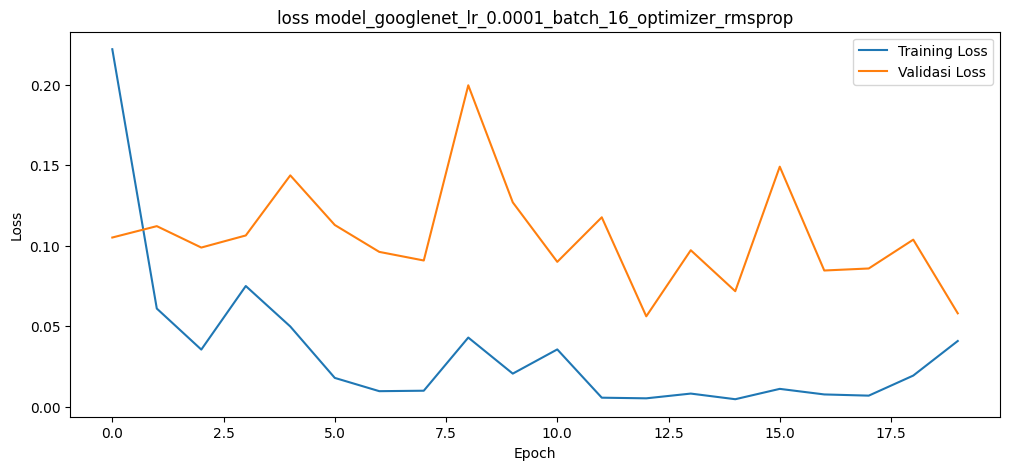

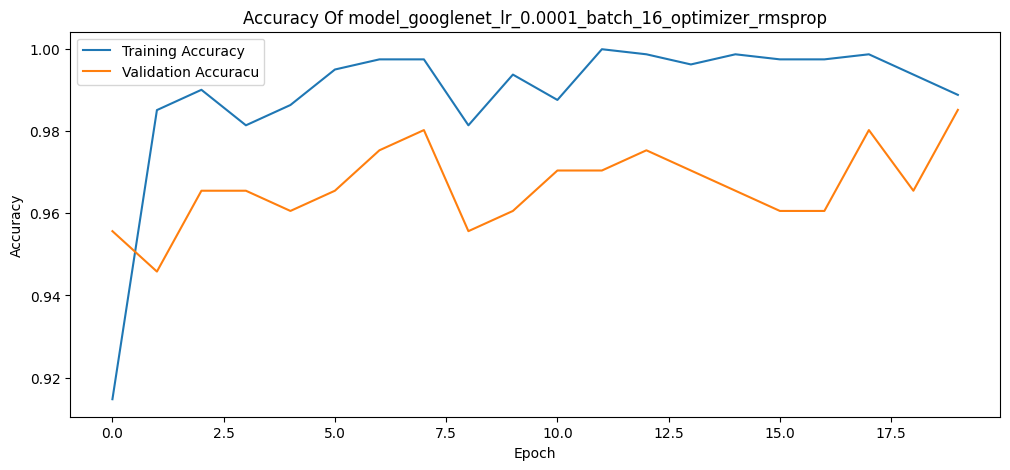

In [ ]:
classifier.best_model_graph()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Hasil Testing


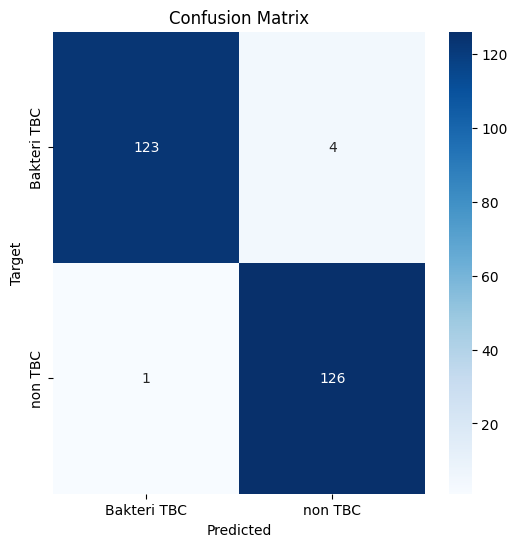

Loss : 0.09737893825513311
Accuracy : 0.9803149606299213
Precision : 0.980583131313324
Recall : 0.9803149700164795
F1-score : 0.9803121984004974


In [ ]:
classifier.predict(xtest, ytest, 'cpu')

## D. ResNet 152 V2


In [ ]:
classifier = Classification("resnet152v2")
classifier.fit(xtrain_val, ytrain_val, xval, yval, 'cuda')

Downloading: "https://download.pytorch.org/models/resnet152-f82ba261.pth" to /root/.cache/torch/hub/checkpoints/resnet152-f82ba261.pth
100%|██████████| 230M/230M [00:02<00:00, 112MB/s]


Tunning model_resnet152v2_lr_0.001_batch_16_optimizer_adam
Epoch : 1 train loss : 0.3385655656091723 train acc : 0.8677379480840544 val loss : 2.3322986559225964 val acc : 0.8669950738916257 
Menyimpan Model
Epoch : 2 train loss : 0.3620561352547477 train acc : 0.865265760197775 val loss : 0.35003709391905713 val acc : 0.8916256157635468 
Epoch : 3 train loss : 0.24372039983669916 train acc : 0.9196538936959209 val loss : 0.295933339279145 val acc : 0.9261083743842364 
Menyimpan Model
Epoch : 4 train loss : 0.20550506934523582 train acc : 0.9394313967861557 val loss : 0.3852212108098544 val acc : 0.8916256157635468 
Menyimpan Model
Epoch : 5 train loss : 0.15629442288156817 train acc : 0.9468479604449939 val loss : 0.4907638135437782 val acc : 0.9310344827586207 
Menyimpan Model
Epoch : 6 train loss : 0.11416396250327428 train acc : 0.9604449938195303 val loss : 0.17483706586062908 val acc : 0.9359605911330049 
Menyimpan Model
Epoch : 7 train loss : 0.1505840137308719 train acc : 0.945

Berhasil Load pkl drive/MyDrive/project/TBC-Project/performa/perform_model_resnet152v2_lr_0.0001_batch_64_optimizer_adam.pkl
Training Time for 434.75193071365356


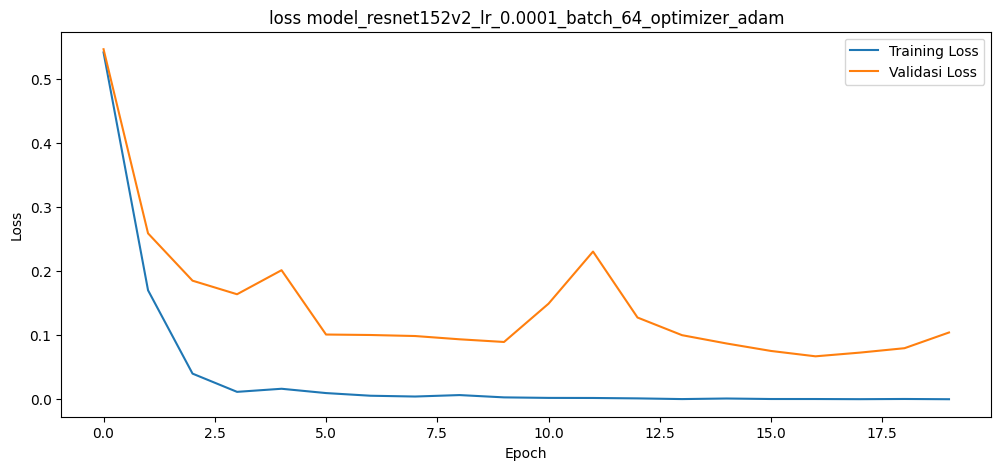

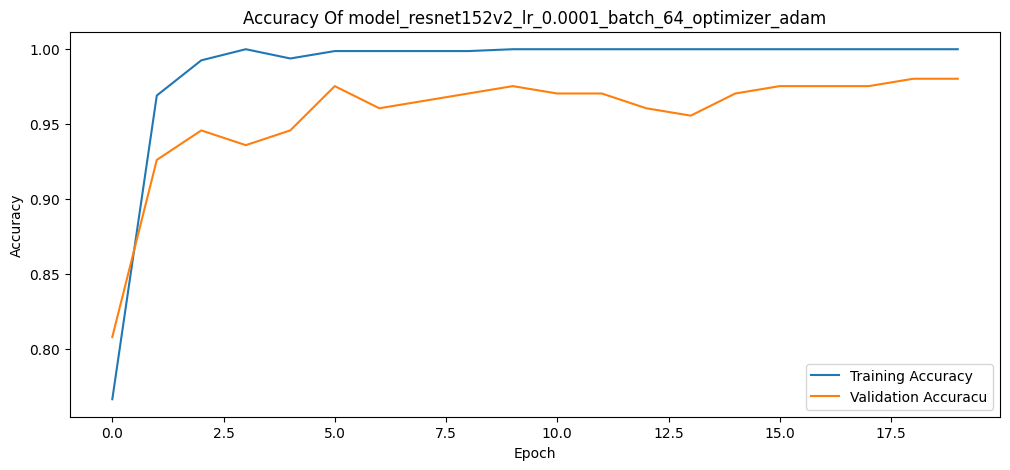

In [ ]:
classifier.best_model_graph()

Hasil Testing


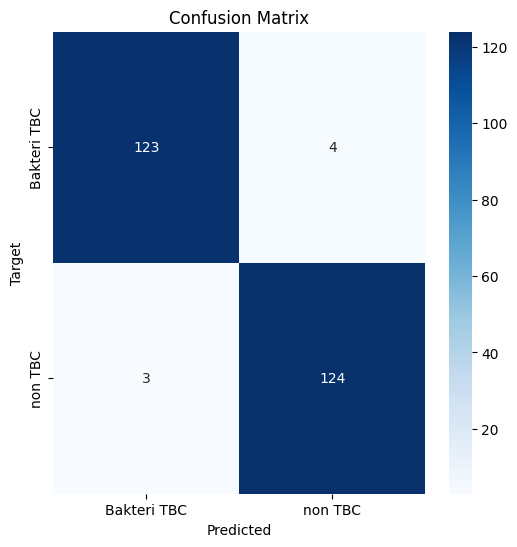

Loss : 0.08943207026459277
Accuracy : 0.9724409448818898
Precision : 0.972470223903656
Recall : 0.9724409580230713
F1-score : 0.9724405109882355


In [ ]:
classifier.predict(xtest, ytest, 'cpu')

## E. MobileNetV2

In [ ]:
classifier = Classification("mobilenetv2")
classifier.fit(xtrain_val, ytrain_val, xval, yval, 'cuda')

Tunning model_mobilenetv2_lr_0.001_batch_16_optimizer_adam
Epoch : 1 train loss : 0.5856256712885464 train acc : 0.695920889987639 val loss : 0.6948504218688378 val acc : 0.4975369458128079 
Menyimpan Model
Epoch : 2 train loss : 0.37449776337427254 train acc : 0.8393077873918418 val loss : 0.33369828244814503 val acc : 0.8374384236453202 
Menyimpan Model
Epoch : 3 train loss : 0.2879527437628484 train acc : 0.8838071693448702 val loss : 0.28256288457375306 val acc : 0.9014778325123153 
Menyimpan Model
Epoch : 4 train loss : 0.24707465450845512 train acc : 0.9134734239802225 val loss : 0.31410704954312396 val acc : 0.8817733990147784 
Menyimpan Model
Epoch : 5 train loss : 0.21820017921866156 train acc : 0.927070457354759 val loss : 0.2724239109800412 val acc : 0.8866995073891626 
Menyimpan Model
Epoch : 6 train loss : 0.1936662316906686 train acc : 0.9221260815822002 val loss : 0.2080772232550841 val acc : 0.9211822660098522 
Menyimpan Model
Epoch : 7 train loss : 0.1748722498396448 t

Berhasil Load pkl drive/MyDrive/project/TBC-Project/performa/perform_model_mobilenetv2_lr_0.001_batch_16_optimizer_adam.pkl
Training Time for 76.88258028030396


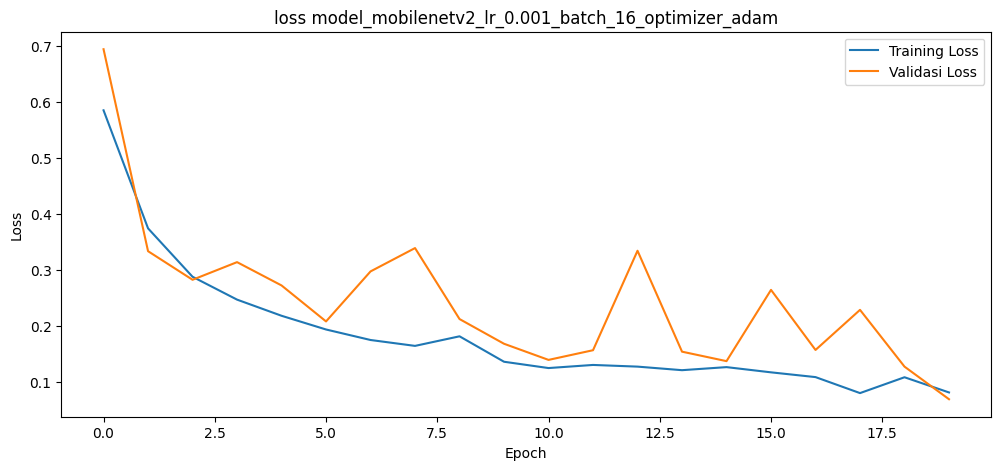

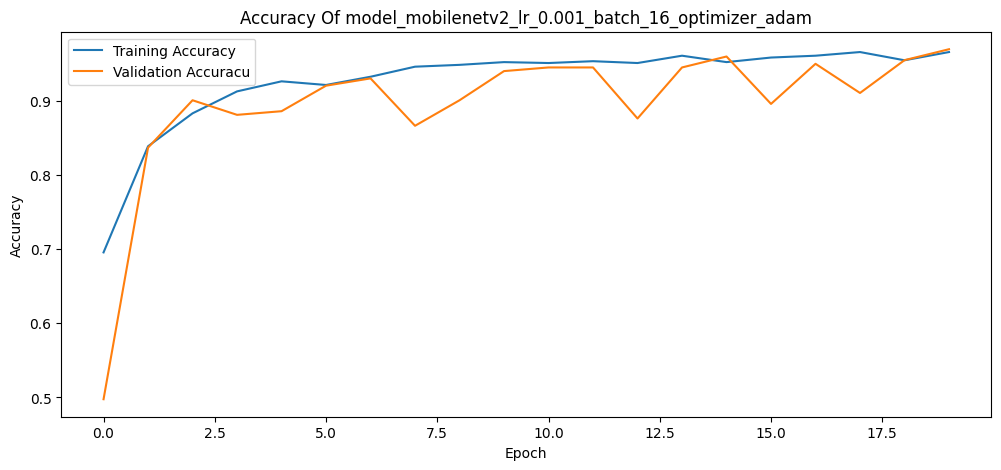

In [ ]:
classifier.best_model_graph()

Hasil Testing


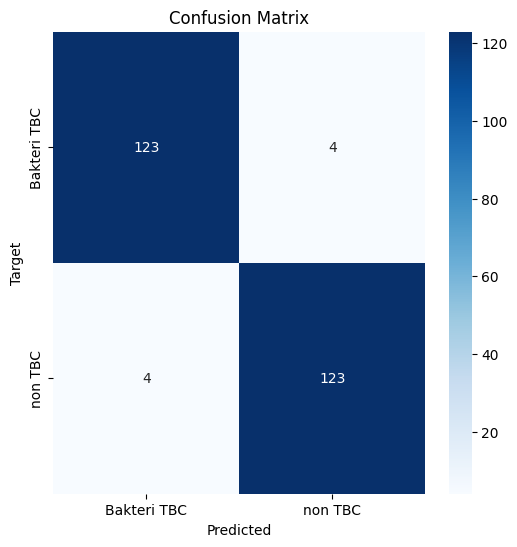

Loss : 0.11878510807582643
Accuracy : 0.968503937007874
Precision : 0.9685039520263672
Recall : 0.9685039520263672
F1-score : 0.9685039520263672


In [ ]:
classifier.predict(xtest, ytest, 'cpu')